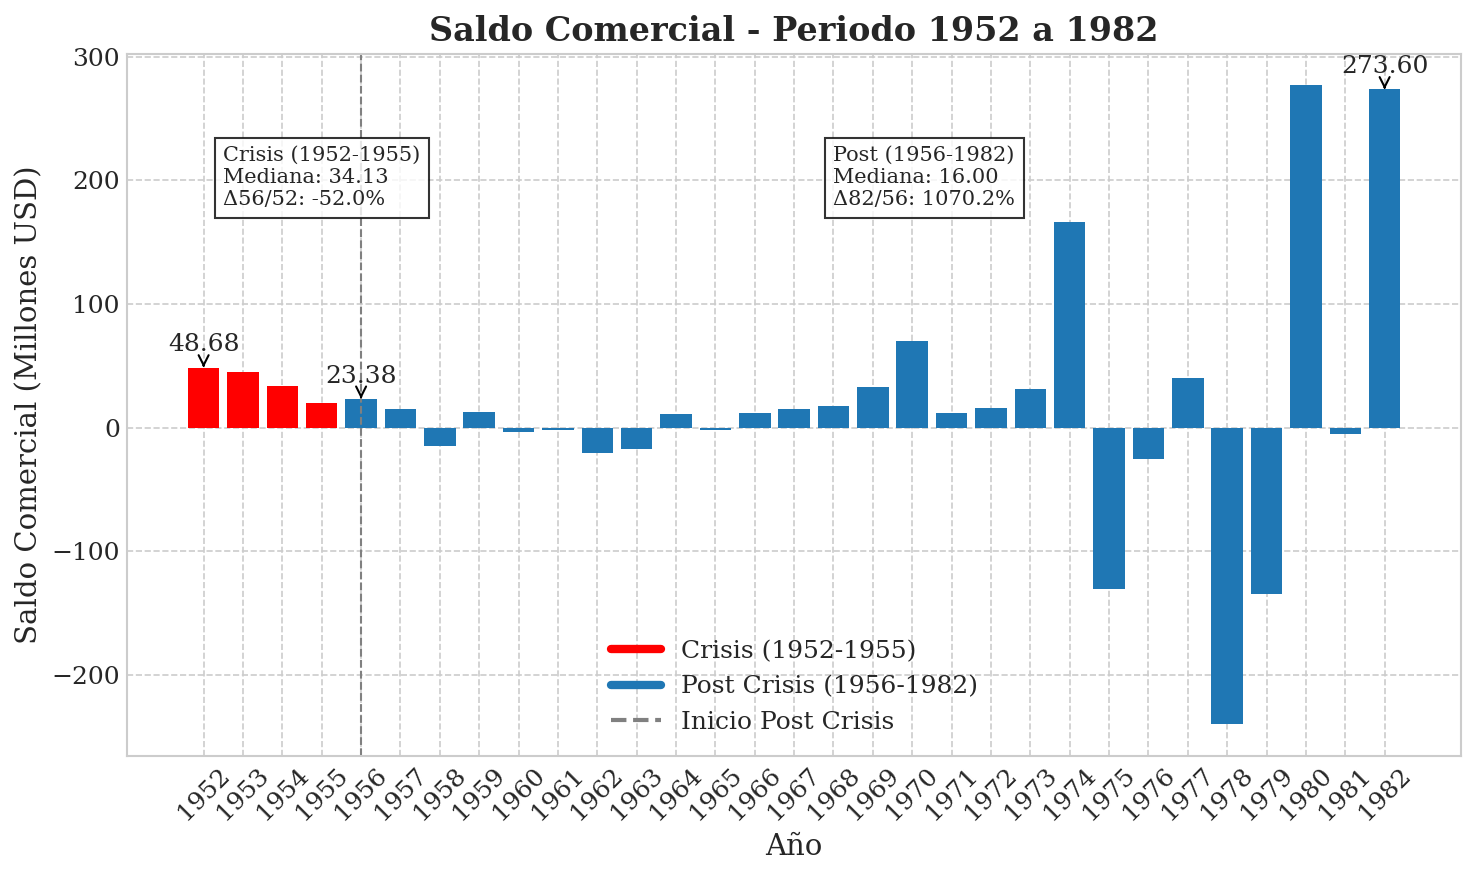

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import os
import seaborn as sns

# --- Configuración del estilo profesional ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'grid.linestyle': '--',
    'lines.linewidth': 2,
    'figure.dpi': 150,
    'savefig.bbox': 'tight'
})
def cuadro_estadisticas(serie):
    mean = serie.mean()
    g56  = (serie.loc[1956] - serie.loc[1952]) / serie.loc[1952] * 100
    return (f"Crisis (1952‑1955)\nMediana: {mean:.2f}\n"
            f"Δ56/52: {g56:.1f}%")

def cuadro_estadisticas_post(serie):
    mean = serie.loc[1956:1982].mean()
    g56  = 0                                 # ya es el punto inicial post‑crisis
    g82  = (serie.loc[1982] - serie.loc[1956]) / serie.loc[1956] * 100
    return (f"Post (1956‑1982)\nMediana: {mean:.2f}\n"
            f"Δ82/56: {g82:.1f}%")
# --- Conexión y carga de datos ---
conn = sqlite3.connect('../../../db/proyectomacro.db')
df_balanza = pd.read_sql_query("SELECT * FROM balanza_comercial", conn)
conn.close()

# --- Preprocesamiento: establecer el índice y recortar al periodo deseado ---
df_balanza.set_index('año', inplace=True)
df_balanza = df_balanza.loc[1952:1982]

# --- Segmentar los datos en pre crisis y post crisis ---
df_pre = df_balanza.loc[1952:1956]
df_post = df_balanza.loc[1956:1982]
df_full = df_balanza  # Para anotaciones y cuadros



# --- Creación del gráfico de barras ---
fig, ax = plt.subplots(figsize=(10,6))

# Colores diferenciados para cada periodo
colors = ['red' if año < 1956 else '#1f77b4' for año in df_full.index]

# Gráfico de barras
bars = ax.bar(df_full.index, df_full['saldo_comercial'], color=colors)

# Línea vertical separadora en 1956
ax.axvline(x=1956, color='gray', linestyle='--', linewidth=1, label='Inicio Post Crisis')

# Anotaciones en años clave: 1952, 1956 y 1982
for year in [1952, 1956, 1982]:
    if year in df_full.index:
        value = df_full.loc[year, 'saldo_comercial']
        ax.annotate(f"{value:.2f}",
                    xy=(year, value),
                    xytext=(year, value +13),
                    ha='center',
                    fontsize=12,
                    arrowprops=dict(facecolor='black', arrowstyle='->'))

# Cuadros de estadísticas descriptivas
ax.text(1952.5, df_full['saldo_comercial'].max() * 0.65, cuadro_estadisticas(df_pre['saldo_comercial']),
        fontsize=10, bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))
ax.text(1968, df_full['saldo_comercial'].max() * 0.65, cuadro_estadisticas_post(df_post['saldo_comercial']),
        fontsize=10, bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

# Etiquetas y leyenda
ax.set_title('Saldo Comercial - Periodo 1952 a 1982', fontweight='bold')
ax.set_xlabel('Año')
ax.set_ylabel('Saldo Comercial (Millones USD)')
ax.set_xticks(df_full.index)
ax.set_xticklabels(df_full.index, rotation=45)
ax.legend(handles=[
    plt.Line2D([0], [0], color='red', lw=4, label='Crisis (1952-1955)'),
    plt.Line2D([0], [0], color='#1f77b4', lw=4, label='Post Crisis (1956-1982)'),
    plt.Line2D([0], [0], color='gray', lw=2, linestyle='--', label='Inicio Post Crisis')
])

plt.tight_layout()

# --- Guardar imagen ---
output_dir = "../../../assets/tesis/intervensionismo_estatal/serie_completa"
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, "saldo_comercial.png"))
plt.show()
